In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import joblib



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

In [8]:
#1.Load dataset and check fraud vs non-fraud counts to understand imbalance.
df = pd.read_csv("Kaggle Credit Card Fraud Dataset.csv")

print(df.head())
print(df.shape)

# Fraud vs Non-Fraud count
print(df['Class'].value_counts())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [9]:
#2.Separate features and target column and remove non-useful identifiers.
X = df.drop('Class', axis=1)
y = df['Class']

print(X.shape)
print(y.shape)


(284807, 30)
(284807,)


In [10]:
#3.Split dataset using stratified sampling so fraud ratio stays similar in train and test.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:",y_train.value_counts())
print("Test:",y_test.value_counts())


Train: Class
0    227451
1       394
Name: count, dtype: int64
Test: Class
0    56864
1       98
Name: count, dtype: int64


In [11]:
#4.Train a baseline model like Logistic Regression for comparison.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000)

lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))



Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.83      0.63      0.72        98

    accuracy                           1.00     56962
   macro avg       0.91      0.82      0.86     56962
weighted avg       1.00      1.00      1.00     56962



In [12]:
#5.Train Random Forest model
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


In [13]:
#6.Predict and evaluate using precision, recall, F1-score instead of accuracy.
print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



   Feature  Importance
17     V17    0.170325
14     V14    0.136363
12     V12    0.133326
10     V10    0.074073
16     V16    0.071792


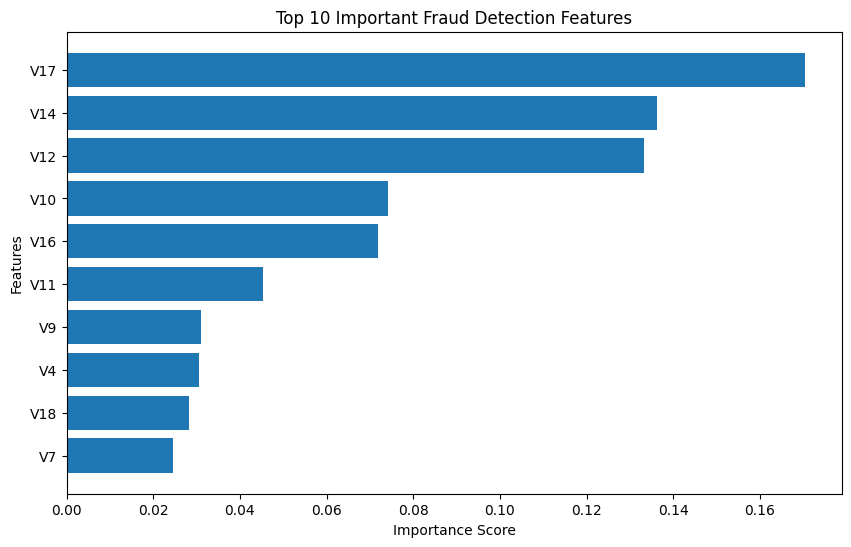

In [14]:
#7.Plot feature importances to identify key fraud indicators.
importances = rf.feature_importances_

feature_names = X.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df.head())

plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Top 10 Important Fraud Detection Features")
plt.gca().invert_yaxis()
plt.show()


In [15]:
#8.Compare Random Forest performance against baseline model.
from sklearn.metrics import precision_score, recall_score, f1_score

lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall],
    'F1-Score': [lr_f1, rf_f1]
})

print(comparison_df)


                 Model  Precision    Recall  F1-Score
0  Logistic Regression   0.826667  0.632653  0.716763
1        Random Forest   0.941176  0.816327  0.874317


In [12]:
#9.Save best model using joblib for reuse.
joblib.dump(rf, "fraud_detection_model.pkl")
print("Model Saved Successfully")


Model Saved Successfully
